In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 1° Leitura e tratamento inicial dos dados

Lendo a CSV e removendo todos os dados com valores de Tp_est iguais a zero. Além disso, foi realizado o tratamento inicial e construção das 3 bases de dados usados no algoritmo

Resultados:
- Base de dados raw para treinamento (*df_raw_train*)
- Base de dados raw para validação (*df_raw_validation*)
- Base de dados raw para teste (*df_raw_test*)

In [2]:
df_raw_data = pd.read_csv('Dados_Radar_Estacao_Completo_2018_2022.csv')
df_raw_data.drop(df_raw_data[df_raw_data['Tp_est'] == 0.0].index, inplace=True);

Remoção de colunas da base geral (2018 a 2022). A colunas removidas foram:
- Unnamed: 0 pois é a coluna de ids
- latitude e longitude pois possuem a mesma informação que as colunas lat e lon;
- distancia pois não agrega valor ao modelo.


In [3]:
df_raw_data.drop(['Unnamed: 0', 'latitude', 'longitude', 'distancia'], axis=1, inplace=True)

Separando o raw data entre treinamento e teste. Anos de 2018 a 2021 para treinamento e 2022 para teste.


In [4]:
raw_train_test_group = df_raw_data.groupby(df_raw_data['time'].str.contains('2022'))

df_raw_train = raw_train_test_group.get_group(False).copy()
df_raw_test = raw_train_test_group.get_group(True).copy()

Separando os dados de treinamento, selecionando uma porção dos dados para validação

In [5]:
dates = ['2018-01', '2018-02']

raw_train_validation_group = df_raw_train.groupby(df_raw_train['time'].str.contains('|'.join(dates)))
df_raw_train = raw_train_validation_group.get_group(False).copy()
df_raw_validation = raw_train_validation_group.get_group(True).copy()


Remoção das colunas elevation e sweep pois não possuiam valor agregado na base

Para verificar que as colunas elevation e sweep não possuiam valor agregado, foi utilizado a função describe do pandas. Com esta função, foi possível verificar que ambas possuiam média, minimo e maximo identicos, além de um desvio padrão igual a 0, ou seja, todas as linhas possuiam o mesmo valor.

In [6]:
print(df_raw_train.describe()['elevation'], end="\n\n")
print(df_raw_train.describe()['sweep'])

df_raw_train.drop(['elevation', 'sweep'], axis=1, inplace=True)
df_raw_validation.drop(['elevation', 'sweep'], axis=1, inplace=True)
df_raw_test.drop(['elevation', 'sweep'], axis=1, inplace=True)

count    83083.0
mean         0.5
std          0.0
min          0.5
25%          0.5
50%          0.5
75%          0.5
max          0.5
Name: elevation, dtype: float64

count    83083.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sweep, dtype: float64


### 2° Separação da base de treinamento e criaçao do *input_values*
Resultados:
- Dicionario *dict_train* contendo a base de treinamento separado por estação. Nesta etapa, a base foi transformada em um np.array, tendo os campos *Est, Time, x, y, z, lat, lon e alt* removidos
- Lista *input_values* uma lista ordenanda por tp_est contendo todas as linhas da base de treinamento que possuiam todos os dados preenchidos

OBS: Como foi decidido separar a base por estações, os valores de *x, y, z, lat, lon e alt* não são mais necessários, e por este motivo foram removidos da base

In [7]:
dict_train = {}

df_train_grouped = df_raw_train.groupby(['Est'])
for est in df_train_grouped.groups.keys():
    group = df_train_grouped.get_group(est).copy()
    dict_train[est] = group.drop(['Est', 'time', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1).values.tolist()

Construção da lista *input_values*

In [8]:
df_train_no_na = df_raw_train.dropna()

input_values = []
columns = list(df_train_no_na.head())
for row in df_train_no_na.iterrows():
    row_info = {}
    for col in columns:
        row_info[col] = row[1][col]

    input_values.append(row_info)

input_values = sorted(input_values, key=lambda d: d["Tp_est"])

### 3° KNN Imputation na base de treinamento

Realização de um KNN imputation para cada estação em especifico

Resultados:
- *dict_train* com todas as linhas com valores preenchidos

OBS: Foram realizadas tentativas de Data Imputation por meio da lista *input_values*, buscando pelo vizinho mais proximo em *Tp_est* e *time*, mas a utilização do KNN Imputation obteve o melhor resultado

In [9]:
imputer = KNNImputer(n_neighbors=5)

for est in dict_train:
    dict_train[est] = imputer.fit_transform(dict_train[est])

### 4° Removendo outliers

Verificação dos outliers e remoção deles para cada estação

Resultados:
- Remoção dos dados com tp_est maiores que 12.4

OBS: Os valores acima de 12.4 foram removidos pois representavam uma porcentagem infima da base de treinamento. Além, disso, foram realizadas remoções de outras faixas de dados e esta obteve o melhor resultado

In [10]:
est_data = {}
for est in dict_train:
    data = { '0 - 2.4': 0, '2.5 - 7.4': 0, '7.5 - 12.4': 0, '12.5 - 17.4': 0, '17.5 - 22.4': 0, '22.5 - 27.4': 0, '27.5 - 32.4': 0,  '32.4 - 37.5': 0}
    for row in dict_train[est]:
        if float(row[-1]) < 2.4:
            data['0 - 2.4'] += 1
        elif float(row[-1]) < 7.4:
            data['2.5 - 7.4'] += 1
        elif float(row[-1]) < 12.4:
            data['7.5 - 12.4'] += 1
        elif float(row[-1]) < 17.4:
            data['12.5 - 17.4'] += 1
        elif float(row[-1]) < 22.4:
            data['17.5 - 22.4'] += 1
        elif float(row[-1]) < 27.4:
            data['22.5 - 27.4'] += 1
        elif float(row[-1]) < 32.4:
            data['27.5 - 32.4'] += 1
        else:
            data['32.4 - 37.5'] += 1
    est_data[est] = data

est_data

{'Aguas_do_Vere': {'0 - 2.4': 4267,
  '2.5 - 7.4': 404,
  '7.5 - 12.4': 71,
  '12.5 - 17.4': 17,
  '17.5 - 22.4': 5,
  '22.5 - 27.4': 0,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Altonia': {'0 - 2.4': 2685,
  '2.5 - 7.4': 297,
  '7.5 - 12.4': 53,
  '12.5 - 17.4': 21,
  '17.5 - 22.4': 5,
  '22.5 - 27.4': 3,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Assis_Chateaubriand': {'0 - 2.4': 3273,
  '2.5 - 7.4': 289,
  '7.5 - 12.4': 54,
  '12.5 - 17.4': 14,
  '17.5 - 22.4': 7,
  '22.5 - 27.4': 3,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Baixo_Iguacu': {'0 - 2.4': 3606,
  '2.5 - 7.4': 367,
  '7.5 - 12.4': 61,
  '12.5 - 17.4': 16,
  '17.5 - 22.4': 11,
  '22.5 - 27.4': 3,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 1},
 'Bela_Vista_Jusante': {'0 - 2.4': 571,
  '2.5 - 7.4': 59,
  '7.5 - 12.4': 5,
  '12.5 - 17.4': 3,
  '17.5 - 22.4': 0,
  '22.5 - 27.4': 1,
  '27.5 - 32.4': 0,
  '32.4 - 37.5': 0},
 'Boa_Vista_da_Aparecida': {'0 - 2.4': 3621,
  '2.5 - 7.4': 322,
  '7.5 - 12.4': 51,
  '12.5 - 17.4': 22,
  '

In [11]:
new_dict_train = {}
for est in dict_train:
    indexes = []
    for index, row in enumerate(dict_train[est]):
        if row[-1] >= 12.4:
            indexes.append(index)
    temp = np.delete(dict_train[est], indexes, 0)
    new_dict_train[est] = temp

dict_train = new_dict_train

### 5° Preparação da base de validação
Realização do Data Imputation na base de validação.

Resultados:
- Base de validação com todas as linhas com valores preenchidos (*df_validation*)

OBS: Não foi utilizado o KNN Imputation pois os dados deste Data Imputation são oriundos da base de treinamento, e não da própia base de validação

In [12]:
df_validation = df_raw_validation.copy()

Realizando o input na base de dados de validação

O input foi realizado por meio da busca do vizinho mais proximo em *Tp_est* na lista input_values

In [13]:
def get_fields_to_input(row, columns):
    fields = []
    for col in columns:
        if str(row[col]) == 'nan':
            fields.append(col)
    return fields

def get_data(tp_est, input_values):
    data = None
    min_distance = math.inf
    for value in input_values:
        distance = abs(tp_est - value["Tp_est"])
        if distance < min_distance:
            min_distance = distance
            data = value

    return data

columns = list(df_validation.head())
for row in df_validation.iterrows():

    fields_to_input = get_fields_to_input(row[1], columns)
    if len(fields_to_input) > 0:
        input_data = get_data(row[1]["Tp_est"], input_values)
        for field in fields_to_input:
            if str(row[1][field]) == 'nan':
                df_validation.loc[row[0], field] = input_data[col]

### 6° Validaçao dos modelos de regressão

Validação dos 4 modelos de regressão utilizados:
- Linear Regression
- Tree Regresion
- SVR
- KNN

Com os resultados obtidos, uma nova clusterização da base de treinamento foi montada

Resultados:
- Validação dos modelos para construção dos clusters finais de dados para o treinamento dos modelos finais


In [14]:
df_validation_for_train = df_validation.drop(['time','Est', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1)

Realizando o treinamento dos modelos e armazenando os valores das predições para calcular os erros e fazer comparações

In [15]:
def get_model(model):
    match model:
        case 'knn':
            return neighbors.KNeighborsRegressor(n_neighbors=100)
        case 'svr':
            return svm.SVR()
        case 'linear_regression':
            return linear_model.LinearRegression()
        case 'tree_regression':
            return tree.DecisionTreeRegressor()

models = ['knn', 'svr', 'linear_regression', 'tree_regression']
est_preds = {}

validate_list = np.array(df_validation_for_train.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

for est in dict_train:
    train_list = dict_train[est]
    x_train = train_list[:, :-1]
    y_train = train_list[:, -1]

    preds = {}
    for model_type in models:
        model = get_model(model_type)
        model.fit(x_train, y_train)

        pred = model.predict(x_validate)
        preds[model_type] = pred

    est_preds[est] = preds

Construção de um dicionário armazenando os erros de predição para cada estação

In [16]:
errors = {}
for est in est_preds:
    est_errors = {}
    for model in est_preds[est]:
        mse = mean_squared_error(y_validate, est_preds[est][model])
        mae = mean_absolute_error(y_validate, est_preds[est][model])
        est_errors[model] = { 'mse': mse, 'mae': mae }
    errors[est] = est_errors

Construindo uma tabela de comparação para tomar decisões sobre os resultados obtidos

In [17]:
df_comparison = pd.DataFrame(columns=['Estação', 'Melhor Modelo MSE', 'MSE', 'Melhor Modelo MAE', 'MAE'])

for est in errors:
    min_mse = None
    min_mse_value = math.inf
    min_mae = None
    min_mae_value = math.inf

    for model in errors[est]:
        if errors[est][model]['mse'] < min_mse_value:
            min_mse = model
            min_mse_value = errors[est][model]['mse']
        if errors[est][model]['mae'] < min_mae_value:
            min_mae = model
            min_mae_value = errors[est][model]['mae']
    new_row = [est, min_mse, min_mse_value, min_mae, min_mae_value]
    df_comparison.loc[len(df_comparison)] = new_row

df_comparison

,Estação,Melhor Modelo MSE,MSE,Melhor Modelo MAE,MAE
0,Aguas_do_Vere,knn,5.669305,svr,1.012452
1,Altonia,knn,5.862485,svr,1.009193
2,Assis_Chateaubriand,knn,6.010499,svr,1.009185
3,Baixo_Iguacu,linear_regression,5.995998,svr,1.009192
4,Bela_Vista_Jusante,knn,5.996519,svr,1.009194
5,Boa_Vista_da_Aparecida,linear_regression,5.426644,svr,1.009186
6,Campo_Mourao,linear_regression,5.655591,svr,1.009189
7,Cascavel,knn,6.118144,svr,1.007859
8,Coronel_Domingos_Soares,linear_regression,5.889198,svr,1.012463
9,Derivacao_do_Rio_Jordao,knn,6.392386,svr,1.009194


### 7° Clusterização final da base de treinamento

Com os resultados obtidos na validação, a base de treinamento foi separado em 2 clustes, um para treinar um KNN Regressor e o outro para treinar um Linear Regressor

Resultados:
- Criação do dicionário *cluster_train* para o treinamento dos modelos finais

In [18]:
clusters = { 'knn': [], 'linear_regression': [] }
for row in df_comparison.iterrows():
    clusters[row[1]['Melhor Modelo MSE']].append(row[1]['Estação'])
    
cluster_train = {}

for cluster in clusters:
    group = dict_train[clusters[cluster][0]]
    for index in range(1, len(clusters[cluster])):
        group = np.concatenate((group, dict_train[clusters[cluster][index]]), axis=0)
    cluster_train[cluster] = group

### 8° validação do valor do k para o KNN Regressor

Utilização de uma 'Cross validation' para testar valores de 1 a 300 de K, no intuito de encontrar o valor que minimiza o erro MSE para o modelo utilizando a base de validação

Resultados:
- O valor otimo para k

In [19]:
train_list = cluster_train['knn']
x = train_list[:, :-1]
y = train_list[:, -1]

validate_list = np.array(df_validation_for_train.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

min_mse = math.inf
mses = []
for k in range(1, 300):
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x, y)
    pred = model.predict(x_validate)
    mse = mean_squared_error(y_validate, pred)
    if mse < min_mse:
        min_mse = mse

    mses.append(mse)

Gráfico da medida MSE de erro para cada K

mse: 6.000267328757119 - 82


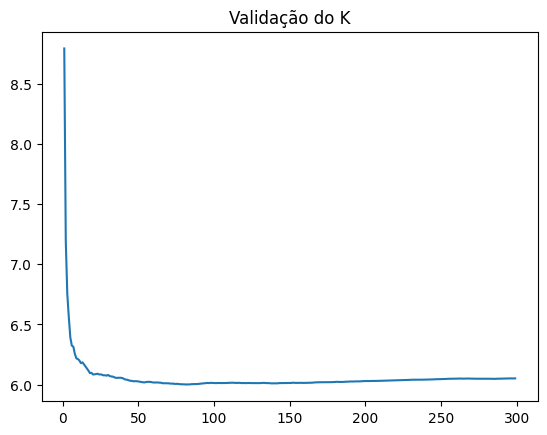

In [20]:
print(f'mse: {min_mse} - {mses.index(min_mse) + 1}')

x = range(1, len(mses) + 1)
y = mses

plt.title('Validação do K')
plt.plot(x, y)
plt.show()

### 9° Preparação da base de teste

Realização do Data Imputation na base de teste

Resultados:
- Base de teste com todas as linhas com valores preenchidos (*df_test*)

OBS: Não foi utilizado o KNN Imputation pois os dados deste Data Imputation são oriundo da base de treinamento, e não da própia base de validação


In [21]:
df_test = df_raw_test.drop(['time','Est', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1)

Realizando o input na base de teste

O input foi realizado por meio da busca do vizinho mais proximo em *Tp_est* na lista input_values

In [22]:
def get_fields_to_input(row, columns):
    fields = []
    for col in columns:
        if str(row[col]) == 'nan':
            fields.append(col)
    return fields

def get_data(tp_est, input_values):
    data = None
    min_distance = math.inf
    for value in input_values:
        distance = abs(tp_est - value["Tp_est"])
        if distance < min_distance:
            min_distance = distance
            data = value

    return data

columns = list(df_test.head())
for row in df_test.iterrows():

    fields_to_input = get_fields_to_input(row[1], columns)
    if len(fields_to_input) > 0:
        input_data = get_data(row[1]["Tp_est"], input_values)
        for field in fields_to_input:
            if str(row[1][field]) == 'nan':
                df_test.loc[row[0], field] = input_data[col]

### 10° Treinamento dos modelos finais

Resultado:
- 1 Modelo KNN Regressor
- 1 Modelo Linear Regressor

In [23]:
knn = neighbors.KNeighborsRegressor(n_neighbors=82)
linear = linear_model.LinearRegression()

knn_train = cluster_train['knn']
linear_train = cluster_train['linear_regression']

x_knn = knn_train[:, :-1]
y_knn = knn_train[:, -1]

x_linear = linear_train[:, :-1]
y_linear = linear_train[:, -1]

knn.fit(x_knn, y_knn)
linear.fit(x_linear, y_linear)

LinearRegression()

### 11° Predições e Resultados

Realização das predições finais para o modelo

Resultados:
- Metricas de erro MSE e MAE
- Gráfico de Dispersão


In [24]:
test_list = np.array(df_test.values.tolist())
x_test = test_list[:, :-1]
y_test = test_list[:, -1]

knn_pred = knn.predict(x_test)
linear_pred = linear.predict(x_test)

final_pred = [a + b for a,b in zip(knn_pred, linear_pred)]
final_pred = [x / 2 for x in final_pred]

Cálculo e print das medidas de erro

In [25]:
mse = mean_squared_error(y_test, final_pred)
mae = mean_absolute_error(y_test, final_pred)

print(f'mse: {mse} - mae: {mae}')

mse: 3.7097849568260273 - mae: 0.9763678466168665


Construção do gráfico de dispersão

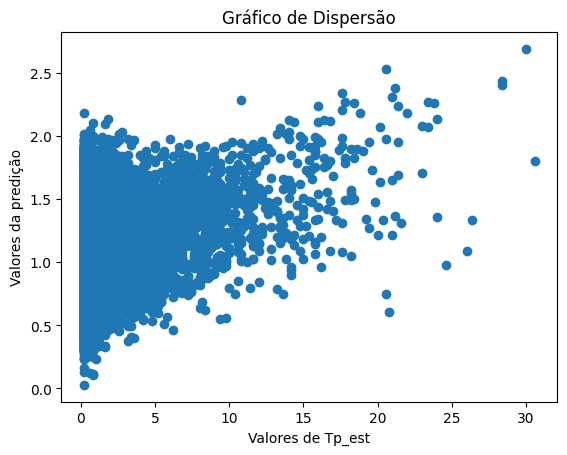

In [26]:
x = y_test
y = final_pred

plt.xlabel('Valores de Tp_est')
plt.ylabel('Valores da predição')
plt.title('Gráfico de Dispersão')
plt.scatter(x, y)
plt.show()